# ToDO:
- Hook, dass die NB Outputs im pre-commit gecleared werden

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from google.cloud import bigquery as bq
from tqdm import tqdm

# Import Data

In [41]:
def get_bq_table(table_id, file_path=None, project_id: str = "brain-flash-dev", dataset_id: str = "dagster_common"):
    client = bq.Client(project=project_id)
    table_ref = f"{project_id}.{dataset_id}.{table_id}"

    query = f"SELECT * FROM `{table_ref}`"
    df = client.query(query).to_dataframe()

    if file_path is not None:
        df.to_csv(file_path, index=False)
        print(f"DataFrame saved to {file_path}")
    
    return df

In [42]:
#get_bq_table("CN_data_to_fetch", file_path='data/twins_100.csv')

In [43]:
df = pd.read_csv('data/twins_100.csv')

### Developement

In [44]:
class InputData:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.TEST_ITEM_COMMUNICATIONKEYS = self.data["TEST_ITEM_COMMUNICATIONKEY"].unique()
        self.TWIN_ITEM_COMMUNICATIONKEYS = self.data["TWIN_ITEM_COMMUNICATIONKEY"].unique()
        
    def prepare_data(self, num_twins: int, key: int) -> pd.DataFrame:

        #warning, when wanted num_twins higher than twin count
        #at one point i should check that the test length is the same as the twin max length
        # print out quick summary of the data (start date, end date etc)
        # beidees berechnen, nur eines zurückgeben

        if num_twins == 0:
            #case: test item
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)
        else:
            #case: twin items
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] != self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)

            # reduce to wanted number of twin items
            df = df.iloc[:, :5]

        df = df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")

        #reconsider the method of this step
        print(f"There are {df.isna().sum().sum()} NaN values in the data which are replaced with 0s.")
        df.fillna(0, inplace=True)
        return df

In [182]:
class Sampling:
    num_samples = 5000 # maintained on class level to ensure comparability between experiments

    @classmethod
    def iid_bootstrap(cls, data: pd.DataFrame) -> pd.Series:
        """Performs IID bootstrap resampling on the dataset."""

        n, col = data.shape
        bootstrap_sums = np.zeros(cls.num_samples)

        for i in tqdm(range(cls.num_samples), desc="IID Bootstrap Sampling"):
            row_indices = np.random.choice(n, size=n, replace=True)
            col_indices = np.random.choice(col, size=n, replace=True)
            
            # Fast retrieval using NumPy advanced indexing
            sampled_values = data.values[row_indices, col_indices]
            bootstrap_sums[i] = np.sum(sampled_values)

        return pd.Series(bootstrap_sums, name="Bootstrap_Sums")

    def lbb(self, B: float = 0.1, b: int = 7) -> pd.Series:
        """Performs the Local Block Bootstrap (LBB) method."""
        M = int(np.ceil(self.n / b))  # Number of blocks

        for i in tqdm(range(self.num_samples), desc="Local Block Bootstrap Sampling"):
            bootstrap_sample = []
            col_choice = np.random.randint(0, self.col, size=M)  # Column selection for each block
            
            for m in range(M):
                # Define valid neighborhood range
                J_1m = max(1, m * b - int(self.n * B))
                J_2m = min(self.n - b + 1, m * b + int(self.n * B))
                
                # Draw block starting index (allows overlapping blocks)
                I_m = np.random.randint(J_1m, J_2m)
                
                # Draw block from sample series
                sampled_block = self.data.iloc[I_m - 1 : I_m + b, col_choice[m]]
                bootstrap_sample.extend(sampled_block)
            
            # Shorten the sample series to match the original series length
            self.bootstrap_sums[i] = np.sum(bootstrap_sample[:self.n])

        return pd.Series(self.bootstrap_sums, name="Bootstrap_Sums")
    
    @classmethod
    def lb_bootstrap(cls, data: pd.DataFrame, B:float = 0.1, b: int = 7) -> pd.Series:
        """Performs the Local Block Bootstrap (LBB) method."""
        
        n, col = data.shape

        M = int(np.ceil(n / b))  # Number of blocks

        # Preallocate array instead of using list (faster memory management)
        bootstrap_sample = np.zeros((cls.num_samples, n))

        # Precompute column choices for each bootstrap sample
        col_choices = np.random.randint(0, col, size=(cls.num_samples, M))

        # Precompute Neighborhood window starting index for all blocks
        
        # Precompute Neighborhood window ending index for all 
        
        # Precompute blocks block starting indices for all blocks




        # for i in tqdm(range(self.num_samples), desc="Local Block Bootstrap Sampling"):
        #     # Precompute block starting indices for all blocks
        #     J_1m = np.maximum(1, np.arange(M) * b - int(self.n * B))
        #     J_2m = np.minimum(self.n - b + 1, np.arange(M) * b + int(self.n * B))
        #     I_m = np.random.randint(J_1m, J_2m)  # Draw block start indices

        #     # Extract blocks using NumPy advanced indexing
        #     sampled_blocks = np.array([self.data[I_m[m] - 1 : I_m[m] + b, col_choices[i, m]] for m in range(M)]).flatten()

        #     # Assign sampled values (ensuring correct length)
        #     bootstrap_sample[i, :self.n] = sampled_blocks[:self.n]

        return pd.Series(np.sum(bootstrap_sample, axis=1), name="Bootstrap_Sums")



In [197]:
b = 7
B = 0.1
N = 100  # Number of samples
M = int(np.ceil(N / b))   # Number of blocks
NB = N*B # neighborhood size, must be int
col = 8

(15,)


array([ 0,  7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98])

In [199]:
# start indices the neighborhood window of block m (independent of sample n)
# die windows müssen noch an 0 index angepasst werden?
J_1m = np.maximum(1, np.arange(M) * b - N*B) #(M,0)
J_2m = np.minimum(N - b + 1, np.arange(M) * b + N*B) #(M,0)
print(J_1m)
print(J_2m)

[ 0.  0.  4. 11. 18. 25. 32. 39. 46. 53. 60. 67. 74. 81. 88.]
[10. 17. 24. 31. 38. 45. 52. 59. 66. 73. 80. 87. 94. 94. 94.]


In [ ]:
# sample block starting indices for all blocks (num_samples, M)
I_m = np.random.randint(J_1m, J_2m, size=(N, M)) #(N,M)
pd.DataFrame(I_m)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,6,8,21,29,21,35,34,45,49,62,67,73,89,92,90
1,8,9,14,27,36,40,32,57,64,70,65,83,74,84,90
2,1,11,12,29,24,38,34,40,55,56,79,68,86,86,92
3,1,15,14,30,24,34,43,43,64,61,71,83,79,83,90
4,6,3,18,22,20,28,39,51,64,62,62,84,91,88,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7,3,18,25,32,40,45,58,55,56,66,73,87,93,90
96,1,15,9,30,18,43,43,44,48,71,67,68,79,91,89
97,4,5,21,29,24,42,46,44,52,68,78,77,75,89,91
98,0,5,15,18,28,28,37,43,65,54,78,81,74,90,91


In [205]:
col_choice = np.random.randint(0, col, size=(N, M)) #(N,M)
pd.DataFrame(col_choice)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,7,3,0,4,5,1,5,2,0,4,2,4,0,6
1,0,4,7,6,0,5,1,1,1,3,3,1,3,4,2
2,4,6,5,0,3,0,6,2,5,7,3,4,5,3,4
3,1,0,4,4,2,7,5,0,1,4,7,0,0,6,5
4,3,7,2,4,0,6,4,0,7,5,5,3,4,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6,0,2,4,7,1,1,7,2,0,3,2,3,5,3
96,5,0,5,4,5,4,7,6,2,0,0,0,3,3,1
97,4,0,2,7,4,3,7,5,2,0,6,1,0,5,5
98,6,2,3,2,7,3,7,5,1,6,0,0,1,5,5


In [206]:
twin

TWIN_ITEM_COMMUNICATIONKEY,551971034,585248259,585738281,587081823,596532614,612870460,621904558,621908839,622483735
CALENDAR_DATE,,,,,,,,,
2018-02-10,1.0,0.0,2.0,5.0,1.0,28.0,0.0,2.0,10.0
2018-02-11,2.0,0.0,6.0,1.0,2.0,43.0,0.0,3.0,24.0
2018-02-12,0.0,0.0,4.0,1.0,0.0,23.0,1.0,2.0,6.0
2018-02-13,0.0,0.0,1.0,0.0,3.0,32.0,0.0,11.0,20.0
2018-02-14,1.0,0.0,4.0,1.0,1.0,26.0,0.0,4.0,11.0
...,...,...,...,...,...,...,...,...,...
2018-12-10,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0
2018-12-11,2.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,3.0
2018-12-12,3.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,3.0


In [ ]:
#alle rechenoperationen, die ich loope
#windows M windows, für num_samples
#startindices, M startindices für num_samples
#blöcke, M mal für num_samples
#summen , num_samples mal die summe

In [183]:
data = InputData(df)
test = data.prepare_data(0, 716679764)
Sampling.lb_bootstrap(test)

There are 0 NaN values in the data which are replaced with 0s.
1234567


In [ ]:
#Christian: nur vollständige blöcke mitnehmen, statt auf unvollständige zu kürzen

### Test Area

In [126]:
data = InputData(df)
test = data.prepare_data(0, 716679764)
twin = data.prepare_data(5, 716679764)

There are 0 NaN values in the data which are replaced with 0s.
There are 12 NaN values in the data which are replaced with 0s.


In [127]:
print(test.sum())

TWIN_ITEM_COMMUNICATIONKEY
716679764    564
dtype: int64


In [172]:
sampler = Sampling(twin, num_samples=2500)

IID Bootstrap Sampling: 100%|██████████| 2500/2500 [00:00<00:00, 15346.82it/s]


count    2500.000000
mean      975.494800
std       114.233347
min       635.000000
25%       896.000000
50%       970.000000
75%      1046.000000
max      1458.000000
Name: Bootstrap_Sums, dtype: float64

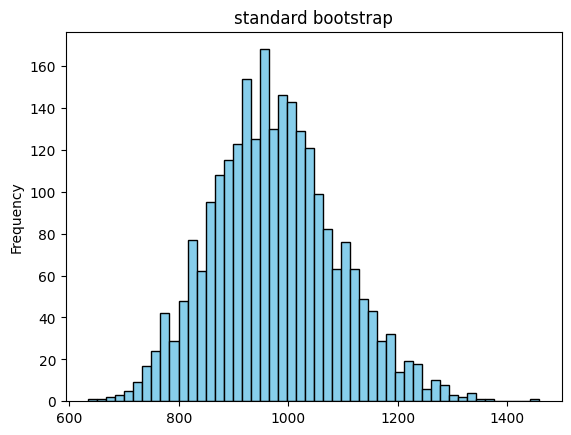

In [158]:
results_simple = sampler.iid_bootstrap()
display(results_simple.describe())
results_simple.plot(kind="hist", title="standard bootstrap", bins=50, color="skyblue", edgecolor="black");

Local Block Bootstrap Sampling:   0%|          | 6/10000 [00:00<06:37, 25.12it/s]

Local Block Bootstrap Sampling: 100%|██████████| 10000/10000 [05:04<00:00, 32.85it/s]


count    10000.000000
mean      1022.016900
std        288.579665
min        331.000000
25%        815.000000
50%       1002.000000
75%       1203.000000
max       2244.000000
Name: Bootstrap_Sums, dtype: float64


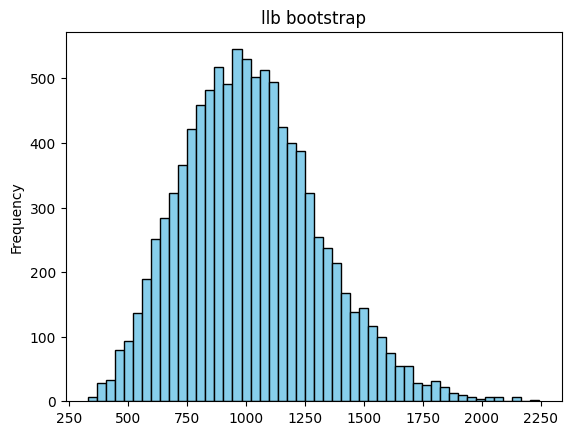

In [150]:
results_lbb = sampler.lbb(B=0.1, b=7)
print(results_lbb.describe())
results_lbb.plot(kind="hist", bins=50, title="llb bootstrap",color="skyblue", edgecolor="black");

In [173]:
results_lbb = sampler.lb_bootstrap(B=0.1, b=7)
print(results_lbb.describe())
results_lbb.plot(kind="hist", bins=50, title="llb bootstrap",color="skyblue", edgecolor="black");

Local Block Bootstrap Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]


InvalidIndexError: (slice(14, 22, None), 8)

$$
W_p(\mu_1, \mu_2) = \left( \int_0^1 \left| F_1^{-1}(q) - F_2^{-1}(q) \right|^p \, dq \right)^{\frac{1}{p}}
$$


In [162]:
class Evaluation:

    @staticmethod
    def mse(test_data: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Squared Error (MSE) as decomposed into bias^2 and variance.
        
        Parameters:
        - test_data: The ground truth value for comparison (assumed seasonal demand sum).
        - bootstrap_samples: A Pandas Series of bootstrap sample estimates.
        
        Returns:
        - MSE value as a float.
        """
        
        # Bias is squared difference between mean of bootstrap samples and sum of test data
        bias = (np.mean(bootstrap_samples) - np.sum(test_data)) ** 2
        
        # Variance of bootstrap samples
        variance = np.var(bootstrap_samples, ddof=1)  # Using sample variance (ddof=1 for unbiased estimator)
        
        mse = bias + variance
        return mse
    
    @staticmethod
    def mape(test_data: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Absolute Percentage Error (MAPE) as a percentage value.
        """
        return np.mean(np.abs(bootstrap_samples - np.sum(test_data)) / np.sum(test_data)) * 100

    @staticmethod
    def mae(test_data: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Absolute Error (MAE).
        """
        return np.mean(np.abs(bootstrap_samples - np.sum(test_data)))

    @staticmethod
    def discrete_wasserstein(dist1: pd.Series, dist2:pd.Series, p: int= 2):
        """
        Compute the p-Wasserstein distance between two discrete one dimensional distributions.
        
        Parameters:
        - dist1: np.array, first distribution samples
        - dist2: np.array, second distribution samples
        - p: int, order of Wasserstein distance
        
        Returns:
        - Wasserstein-p distance (float)
        """
        #sind das die richtigen funktionen?
        dist1_sorted = np.sort(dist1)
        dist2_sorted = np.sort(dist2)
        
        # Compute p-Wasserstein distance
        return np.power(np.sum(np.abs(dist1_sorted - dist2_sorted) ** p) / len(dist1), 1 / p)

In [ ]:
# ToDo: test vs stats package
# why is the statsmethod necessary? or recommended if leaving it out works just fine

# Normality test
- tune number of iteration until distribution is normal

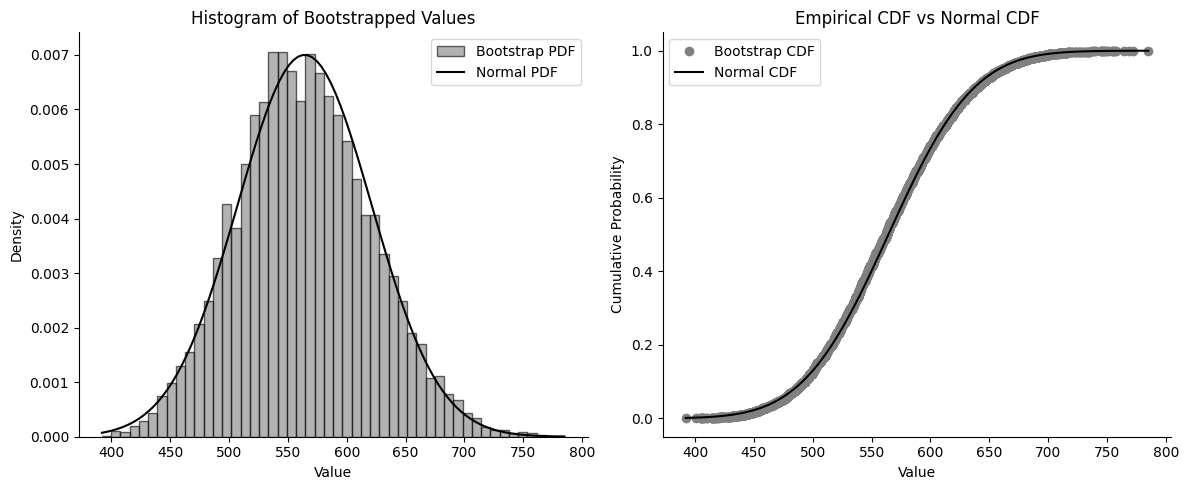

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(results_simple, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(results_simple), max(results_simple), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(results_simple)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [140]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05


In [ ]:
len(results_simple)

In [159]:
res = stats.normaltest(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

1.2311947696684767e-13
Reject the null hypothesis: The data does not appear to be normally distributed.


In [143]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

Reject the null hypothesis: The data does not appear to be normally distributed.


/home/chnaeher/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
